## <font color = red> Agenda

- Retrieval-Augmented Generation (RAG) project called Mr.HelpMate AI to answer questions from a life insurance policy PDF
- System Design Discussion
- Problem Statement
- Project Layers Breakdown
    - Embedding Layer(Load and preprocess PDF, Chunking strategies to test, Embedding model options, Store in VectorDB)
    - Search Layer(Design 3 test queries, Embed and search ChromaDB, Implement caching, Re-ranking step)
    - Generation Layer(Prompt design, Model choices)



## <font color = red> Problem Statement

Design and implement Mr.HelpMate AI, a robust three-layer Retrieval-Augmented Generation (RAG) system, that accurately answers user questions from an insurance policy PDF.




## <font color = red> System Design

- Embedding Layer

   - Effectively extract, clean and chunk the document text using various strategies

   - Evaluate multiple embedding models

- Search Layer

  - Define at least three realistic queries whose answers reside in the policy.

   - Build a vector search pipeline (ChromaDB) with a caching mechanism for speed.

   - Integrate a cross-encoder reranker to improve the relevance of the top-K results.

- Generation Layer

   - Craft an exhaustive prompt that injects the reranked context chunks (and optional few-shot examples) into an LLM (e.g., GPT-3.5/4).

- Evaluation

  - Execute the three queries end-to-end, capturing and get 3 screenshots of the top-3 chunks retrieved (Search Layer) and 3 screenshots of the final generated answers (Generation Layer)

- Analyze system performance and document insights.

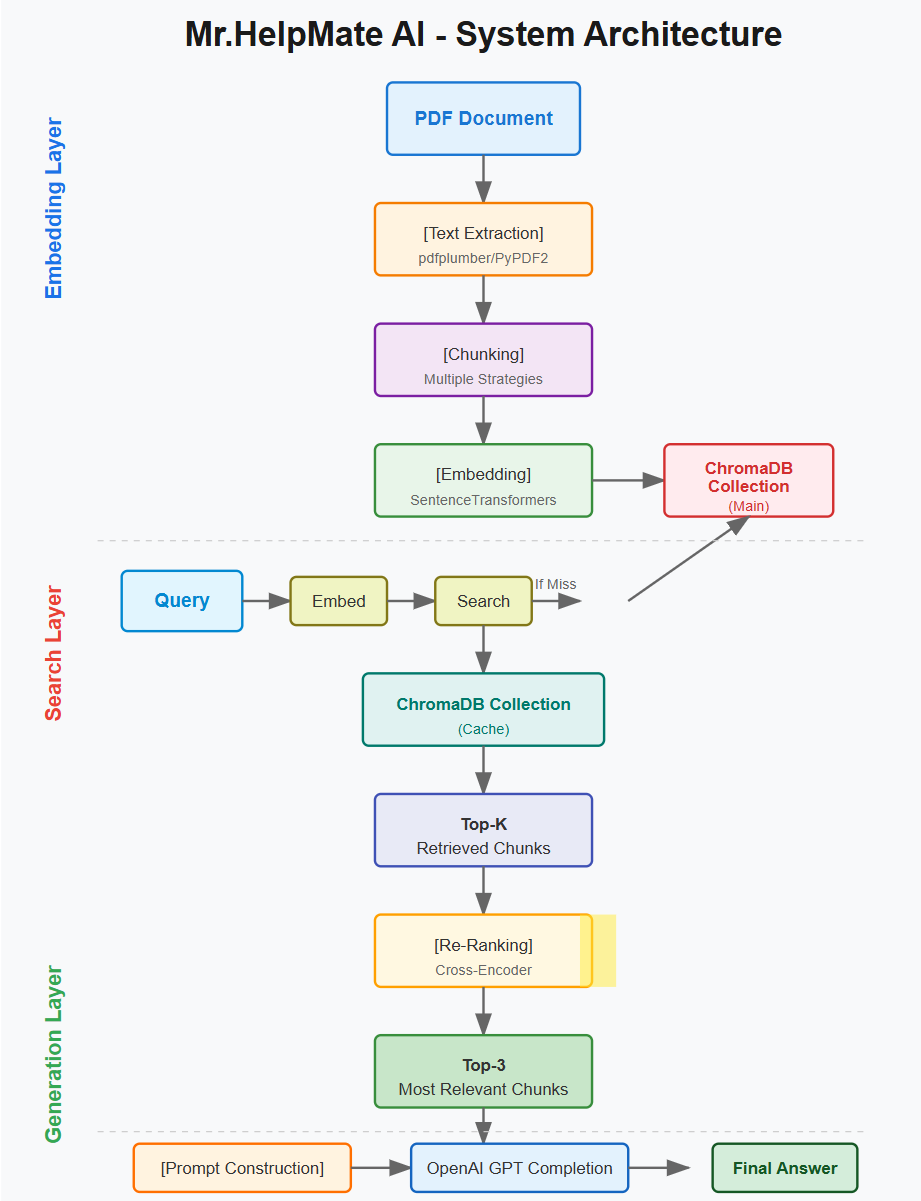

## <font color = red> RAG Implementation

RAG system

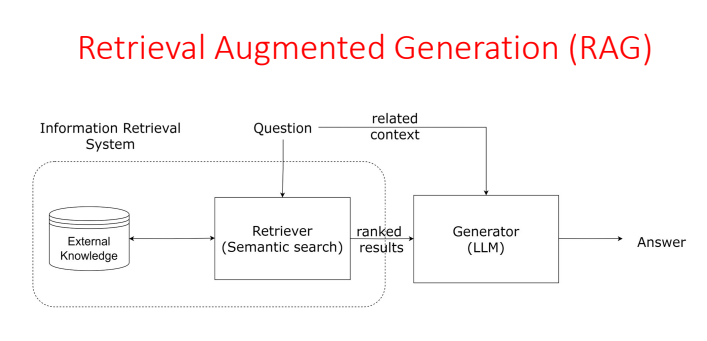

Sample Vector representation
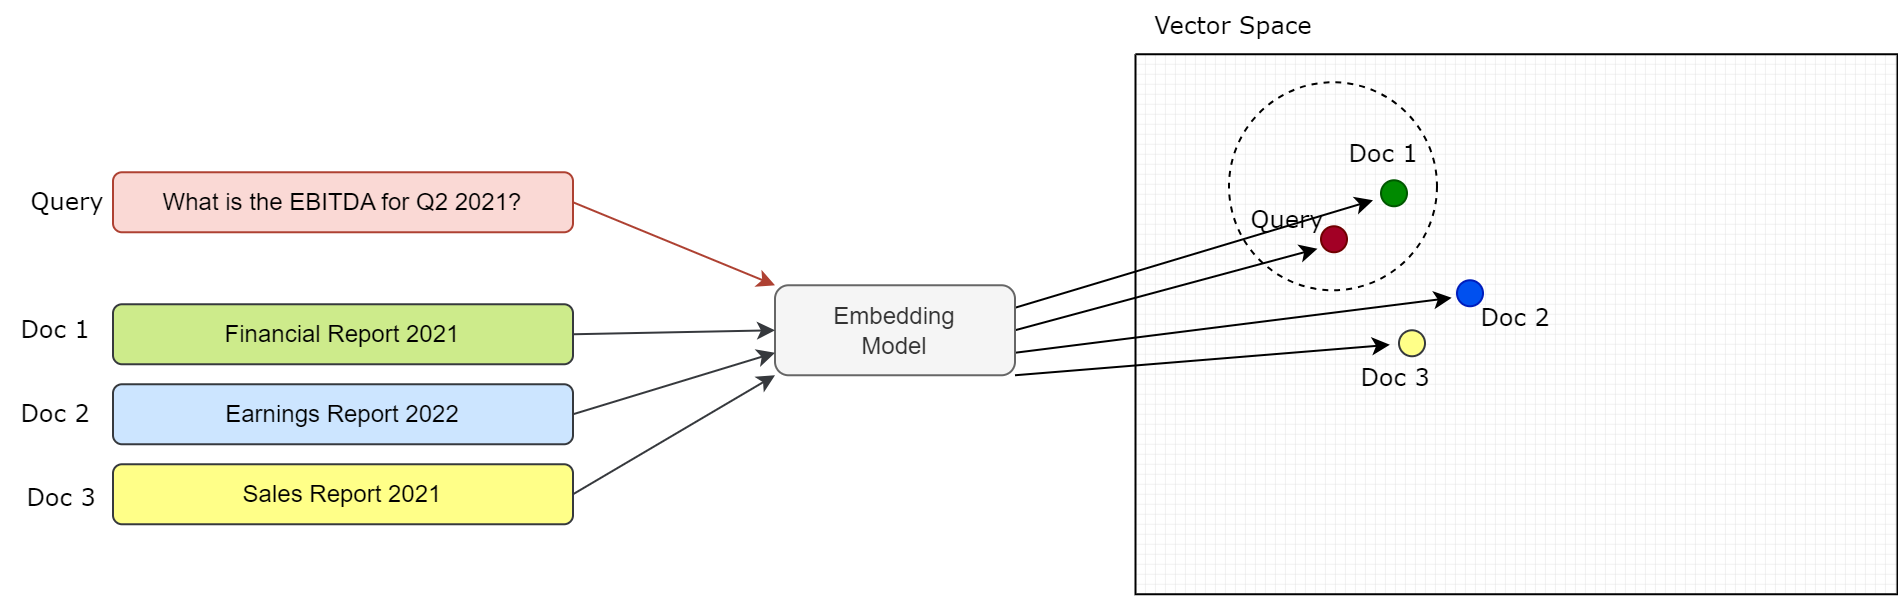

## <font color = red> 1. Install and Import the Required Dependencies

In [306]:
# Install the following packages incase they're not loaded already
!pip install pdfplumber
!pip install chromadb
!pip install tiktoken
!pip install openai

In [307]:
# Import all the required Libraries
import pdfplumber
from pathlib import Path
import pandas as pd
from operator import itemgetter
import json
import tiktoken
import chromadb
import openai
import os


In [308]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [309]:
# Set the API key
filepath = "/content/drive/MyDrive/HelpMateAI_InsurancePolicyQA/"
# File to access - Principal-Sample-Life-Insurance-Policy.pdf

In [310]:
from google.colab import userdata
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')

In [311]:
## Issues with normal LLMs
# If LLM is queried for content on which it is not having access - it will answer something like 'I do not have access to real-time information or databases...'
# Scenario is represented as below where LLM is presenting its inability to present any such information.
# Information is present in specific PDF and with RAG implementation such information can be extracted.

messages = [
    {"role":"system", "content":"You are an AI assistant to user."},
    {"role":"user", "content":"On which date PRINCIPAL LIFE INSURANCE COMPANY issued insurance policy to RHODE ISLAND JOHN DOE"},
          ]

In [312]:
## New method (as older completion and chatcompletion endpoints have been deprecated)
response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages)
response.choices[0].message.content

"I'm sorry, but I cannot provide you with that specific information as it may contain private or sensitive data. It is recommended to contact PRINCIPAL LIFE INSURANCE COMPANY directly for details regarding insurance policies."

As you see the LLMs may not have access to your internal data, and therefore, they won't be able to **retrieve** information beyond the data that they have been trained on

However there's a trick you can use!!

Here's the relevant snippet from Principal-Sample-Life-Insurance-Policy.pdf page 5 aand represent RAG kind of implementation

This group insurance policy is issued to:
RHODE ISLAND JOHN DOE
(called the Policyholder in this Group Policy)
The Date of Issue is November 1, 2007.
In return for the Policyholder's application and payment of all premiums when due, The Principal
agrees to provide:
MEMBER LIFE INSURANCE
MEMBER ACCIDENTAL DEATH AND DISMEMBERMENT INSURANCE
DEPENDENT LIFE INSURANCE
subject to the terms and conditions described in this Group Policy.

In [313]:
retrieved = "This group insurance policy is issued to: RHODE ISLAND JOHN DOE (called the Policyholder in this Group Policy) The Date of Issue is November 1, 2007. In return for the Policyholder's application and payment of all premiums when due, The Principal agrees to provide: MEMBER LIFE INSURANCE MEMBER ACCIDENTAL DEATH AND DISMEMBERMENT INSURANCE DEPENDENT LIFE INSURANCE subject to the terms and conditions described in this Group Policy. "

In [314]:
messages = [
    {"role":"system", "content":"You are an AI assistant to user."},
    {"role":"user", "content":f"""On which date PRINCIPAL LIFE INSURANCE COMPANY issued insurance policy to RHODE ISLAND JOHN DOE. Use the information presented in '{retrieved}' """},
          ]

In [315]:
# Now LLM is able to answer the query with additional information.

response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages)
response.choices[0].message.content

'Principal Life Insurance Company issued the insurance policy to Rhode Island John Doe on November 1, 2007.'

So what we did above was,
- We **retrieved** the information from an external source,
- **Augmented** our query with the relevant information prompt,
- and finally we **generated** the relevant response

This above process is RAG in a nutshell!

### Data Processing

Quite crucial, hence suggested to use good parsers that can load the data from your documents effectively.


In [316]:
pdf_path = "/content/drive/MyDrive/HelpMateAI_InsurancePolicyQA/data"

In [317]:
# Function to check whether a word is present in a table or not for segregation of regular text and tables

def check_bboxes(word, table_bbox):
    # Check whether word is inside a table bbox.
    l = word['x0'], word['top'], word['x1'], word['bottom']
    r = table_bbox
    return l[0] > r[0] and l[1] > r[1] and l[2] < r[2] and l[3] < r[3]

## <font color = red> 2. Preprocess PDF files by Read, Process, and Chunking

In [318]:
# Get single page text

# Open the PDF file and check one page
# Assuming there is at least one PDF in the directory and picking the first one found by glob
import glob
pdf_files = glob.glob(pdf_path + "/*.pdf")
if pdf_files:
    single_pdf_path = pdf_files[0]
    with pdfplumber.open(single_pdf_path) as singlepdf:

        # Get one of the pages from the PDF and examine it
        one_page = singlepdf.pages[4]

        # Extract text from the first page
        text = one_page.extract_text()

        # Extract tables from the first page
        tables = one_page.extract_tables()

        # Print the extracted text
        print(text)
else:
    print("No PDF files found in the specified directory.")

PRINCIPAL LIFE INSURANCE COMPANY
(called The Principal in this Group Policy)
Des Moines, Iowa 50392-0002
This group insurance policy is issued to:
RHODE ISLAND JOHN DOE
(called the Policyholder in this Group Policy)
The Date of Issue is November 1, 2007.
In return for the Policyholder's application and payment of all premiums when due, The Principal
agrees to provide:
MEMBER LIFE INSURANCE
MEMBER ACCIDENTAL DEATH AND DISMEMBERMENT INSURANCE
DEPENDENT LIFE INSURANCE
subject to the terms and conditions described in this Group Policy.
GROUP POLICY NO. GL S655
RENEWABLE TERM - NON-PARTICIPATING
CONTRACT STATE OF ISSUE: RHODE ISLAND
This policy has been updated effective January 1, 2014
GC 6000 TITLE PAGE


In [319]:
# View the table in the page, if any
if len(tables) > 0:
  tables[0]
else:
  print("No tables found")

No tables found


In [320]:
# Function to extract text from a PDF file.
# 1. Declare a variable p to store the iteration of the loop that will help us store page numbers alongside the text
# 2. Declare an empty list 'full_text' to store all the text files
# 3. Use pdfplumber to open the pdf pages one by one
# 4. Find the tables and their locations in the page
# 5. Extract the text from the tables in the variable 'tables'
# 6. Extract the regular words by calling the function check_bboxes() and checking whether words are present in the table or not
# 7. Use the cluster_objects utility to cluster non-table and table words together so that they retain the same chronology as in the original PDF
# 8. Declare an empty list 'lines' to store the page text
# 9. If a text element in present in the cluster, append it to 'lines', else if a table element is present, append the table
# 10. Append the page number and all lines to full_text, and increment 'p'
# 11. When the function has iterated over all pages, return the 'full_text' list

def extract_text_from_pdf(pdf_path):
    p = 0
    full_text = []


    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            page_no = f"Page {p+1}"
            text = page.extract_text()

            tables = page.find_tables()
            table_bboxes = [i.bbox for i in tables]
            tables = [{'table': i.extract(), 'top': i.bbox[1]} for i in tables]
            non_table_words = [word for word in page.extract_words() if not any(
                [check_bboxes(word, table_bbox) for table_bbox in table_bboxes])]
            lines = []

            for cluster in pdfplumber.utils.cluster_objects(non_table_words + tables, itemgetter('top'), tolerance=5):

                if 'text' in cluster[0]:
                    try:
                        lines.append(' '.join([i['text'] for i in cluster]))
                    except KeyError:
                        pass

                elif 'table' in cluster[0]:
                    lines.append(json.dumps(cluster[0]['table']))


            full_text.append([page_no, " ".join(lines)])
            p +=1

    return full_text

Now that we have defined the function for extracting the text and tables from a PDF, let's iterate and call this function for all the PDFs in our drive and store them in a list.

In [321]:
# Define the directory containing the PDF files
pdf_directory = Path(pdf_path)

# Initialize an empty list to store the extracted texts and document names
data = []

# Loop through all files in the directory
for pdf_path in pdf_directory.glob("*.pdf"):

    # Process the PDF file
    print(f"...Processing {pdf_path.name}")

    # Call the function to extract the text from the PDF
    extracted_text = extract_text_from_pdf(pdf_path)

    # Convert the extracted list to a PDF, and add a column to store document names
    extracted_text_df = pd.DataFrame(extracted_text, columns=['Page No.', 'Page_Text'])
    extracted_text_df['Document Name'] = pdf_path.name

    # Append the extracted text and document name to the list
    data.append(extracted_text_df)

    # Print a message to indicate progress
    print(f"Finished processing {pdf_path.name}")

# Print a message to indicate all PDFs have been processed
print("All PDFs have been processed.")

...Processing Principal-Sample-Life-Insurance-Policy.pdf
Finished processing Principal-Sample-Life-Insurance-Policy.pdf
All PDFs have been processed.


In [322]:
insurance_pdfs_data = pd.concat(data, ignore_index=True)

In [323]:
insurance_pdfs_data.head(5)

,Page No.,Page_Text,Document Name
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,Principal-Sample-Life-Insurance-Policy.pdf
1,Page 2,This page left blank intentionally,Principal-Sample-Life-Insurance-Policy.pdf
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,Principal-Sample-Life-Insurance-Policy.pdf
3,Page 4,This page left blank intentionally,Principal-Sample-Life-Insurance-Policy.pdf
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,Principal-Sample-Life-Insurance-Policy.pdf


In [324]:
len(insurance_pdfs_data)

64

In [325]:
# Check one of the extracted page texts to ensure that the text has been correctly read

insurance_pdfs_data.Page_Text[0]

'DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/01/2014 711 HIGH STREET GEORGE RI 02903 GROUP POLICY FOR: RHODE ISLAND JOHN DOE ALL MEMBERS Group Member Life Insurance Print Date: 07/16/2014'

In [326]:
# Let's also check the length of all the texts as there might be some empty pages or pages with very few words that we can drop

insurance_pdfs_data['Text_Length'] = insurance_pdfs_data['Page_Text'].apply(lambda x: len(x.split(' ')))

In [327]:
# Check Text Length column
insurance_pdfs_data['Text_Length']

,Text_Length
0,30
1,5
2,230
3,5
4,110
...,...
59,285
60,418
61,322
62,5


In [328]:
# Retain only the rows with a text length of at least 10, text length < 10 does not carry significant information

insurance_pdfs_data = insurance_pdfs_data.loc[insurance_pdfs_data['Text_Length'] >= 10]
insurance_pdfs_data.head(5)

,Page No.,Page_Text,Document Name,Text_Length
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,Principal-Sample-Life-Insurance-Policy.pdf,30
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,Principal-Sample-Life-Insurance-Policy.pdf,230
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,Principal-Sample-Life-Insurance-Policy.pdf,110
5,Page 6,TABLE OF CONTENTS PART I - DEFINITIONS PART II...,Principal-Sample-Life-Insurance-Policy.pdf,153
6,Page 7,Section A – Eligibility Member Life Insurance ...,Principal-Sample-Life-Insurance-Policy.pdf,176


In [329]:
# Store the metadata for each page in a separate column

insurance_pdfs_data['Metadata'] = insurance_pdfs_data.apply(lambda x: {'Policy_Name': x['Document Name'][:-4], 'Page_No.': x['Page No.']}, axis=1)

/tmp/ipython-input-329-1081778557.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  insurance_pdfs_data['Metadata'] = insurance_pdfs_data.apply(lambda x: {'Policy_Name': x['Document Name'][:-4], 'Page_No.': x['Page No.']}, axis=1)


In [330]:
insurance_pdfs_data.head(5)

,Page No.,Page_Text,Document Name,Text_Length,Metadata
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,Principal-Sample-Life-Insurance-Policy.pdf,30,{'Policy_Name': 'Principal-Sample-Life-Insuran...
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,Principal-Sample-Life-Insurance-Policy.pdf,230,{'Policy_Name': 'Principal-Sample-Life-Insuran...
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,Principal-Sample-Life-Insurance-Policy.pdf,110,{'Policy_Name': 'Principal-Sample-Life-Insuran...
5,Page 6,TABLE OF CONTENTS PART I - DEFINITIONS PART II...,Principal-Sample-Life-Insurance-Policy.pdf,153,{'Policy_Name': 'Principal-Sample-Life-Insuran...
6,Page 7,Section A – Eligibility Member Life Insurance ...,Principal-Sample-Life-Insurance-Policy.pdf,176,{'Policy_Name': 'Principal-Sample-Life-Insuran...


### <font color = red> 3 Generate and Store Embeddings using OpenAI and ChromaDB

---



In this section, we will embed the pages in the dataframe through OpenAI's text-embedding-ada-002 model, and store them in a ChromaDB collection.

In [331]:
# Import the OpenAI Embedding Function into chroma

from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction

In [332]:
# Define the path where chroma collections will be stored

chroma_data_path = "/content/drive/MyDrive/HelpMateAI_InsurancePolicyQA/ChromaDB_Data"

In [333]:
# Call PersistentClient()

client = chromadb.PersistentClient(path=chroma_data_path)

In [334]:
# Set up the embedding function using the OpenAI embedding model

model = "text-embedding-ada-002"
embedding_function = OpenAIEmbeddingFunction(api_key=openai.api_key, model_name=model)

In [335]:
## Create an empty collection
insurancedata_collection = client.get_or_create_collection(name='RAG_on_InsurancePolicy', embedding_function=embedding_function)

In [336]:
documents_list = insurance_pdfs_data["Page_Text"].tolist()
metadata_list = insurance_pdfs_data['Metadata'].tolist()

In [337]:
documents_list

['DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/01/2014 711 HIGH STREET GEORGE RI 02903 GROUP POLICY FOR: RHODE ISLAND JOHN DOE ALL MEMBERS Group Member Life Insurance Print Date: 07/16/2014',
 'POLICY RIDER GROUP INSURANCE POLICY NO: S655 COVERAGE: Life EMPLOYER: RHODE ISLAND JOHN DOE Effective on the later of the Date of Issue of this Group Policy or March 1, 2005, the following will apply to your Policy: From time to time The Principal may offer or provide certain employer groups who apply for coverage with The Principal a Financial Services Hotline and Grief Support Services or any other value added service for the employees of that employer group. In addition, The Principal may arrange for third party service providers (i.e., optometrists, health clubs), to provide discounted goods and services to those employer groups who apply for coverage with The Principal or who become insureds/enrollees of The Principal. While The Principal has arranged these goods, services and/or third par

In [338]:
# Taking help
# ?insurancedata_collection.add

In [339]:
# Add the documents and metadata to the collection along with generic integer IDs. You can also feed the metadata information as IDs by combining the policy name and page no.

# insurancedata_collection.add(
#     documents= documents_list,
#     ids = [str(i) for i in range(0, len(documents_list))],
#     metadatas = metadata_list
# )

# Define batch size based on token estimate (can be adjusted)
batch_size = 100  # or 50 if docs are long

for i in range(0, len(documents_list), batch_size):
    batch_docs = documents_list[i:i+batch_size]
    batch_ids = [str(j) for j in range(i, i+len(batch_docs))]
    batch_meta = metadata_list[i:i+batch_size]

    insurancedata_collection.add(
        documents=batch_docs,
        ids=batch_ids,
        metadatas=batch_meta
    )


In [340]:
insurancedata_collection.peek(1)

{'ids': ['0'],
 'embeddings': array([[-0.0224626 ,  0.01874492, -0.02731515, ..., -0.03691588,
          0.00289751, -0.00126287]]),
 'documents': ['DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/01/2014 711 HIGH STREET GEORGE RI 02903 GROUP POLICY FOR: RHODE ISLAND JOHN DOE ALL MEMBERS Group Member Life Insurance Print Date: 07/16/2014'],
 'uris': None,
 'included': ['metadatas', 'documents', 'embeddings'],
 'data': None,
 'metadatas': [{'Page_No.': 'Page 1',
   'filing_name': 'Principal-Sample-Life-Insurance-Policy'}]}

In [341]:
# Let's take a look at the first few entries in the collection

insurancedata_collection.get(
   ids = ['0','1','2'],
   include = ['embeddings', 'documents', 'metadatas']
)

{'ids': ['0', '1', '2'],
 'embeddings': array([[-2.24625990e-02,  1.87449213e-02, -2.73151454e-02, ...,
         -3.69158834e-02,  2.89750565e-03, -1.26286899e-03],
        [-1.59058738e-02,  8.86123962e-05,  2.63494905e-03, ...,
         -1.70467440e-02,  2.71951966e-03, -2.55236868e-02],
        [-1.32057490e-02,  8.82212631e-03, -4.67860838e-03, ...,
         -1.56548154e-02, -4.84764605e-05,  7.25115696e-03]]),
 'documents': ['DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/01/2014 711 HIGH STREET GEORGE RI 02903 GROUP POLICY FOR: RHODE ISLAND JOHN DOE ALL MEMBERS Group Member Life Insurance Print Date: 07/16/2014',
  'This page left blank intentionally',
  'POLICY RIDER GROUP INSURANCE POLICY NO: S655 COVERAGE: Life EMPLOYER: RHODE ISLAND JOHN DOE Effective on the later of the Date of Issue of this Group Policy or March 1, 2005, the following will apply to your Policy: From time to time The Principal may offer or provide certain employer groups who apply for coverage with The Princi

In [342]:
cache_collection = client.get_or_create_collection(name='Insurance_Cache1', embedding_function=embedding_function)

In [343]:
cache_collection.peek()

{'ids': ['what are premium rate and benefits for each Member insured for Life Insurance?',
  'What are the policy exclusions?',
  'Explain the grace period rules.',
  'How do I file a death claim?'],
 'embeddings': array([[-0.00922895, -0.00162074,  0.02818732, ..., -0.02148749,
         -0.01408031, -0.01965906],
        [ 0.00304126,  0.00026222,  0.01805403, ..., -0.01390685,
          0.00024818, -0.00719535],
        [-0.00287365, -0.00970142,  0.01703528, ..., -0.00641274,
          0.01784781, -0.01202696],
        [ 0.00947184, -0.01002901, -0.00708586, ...,  0.01065828,
          0.00015332, -0.03400688]]),
 'documents': ['what are premium rate and benefits for each Member insured for Life Insurance?',
  'What are the policy exclusions?',
  'Explain the grace period rules.',
  'How do I file a death claim?'],
 'uris': None,
 'included': ['metadatas', 'documents', 'embeddings'],
 'data': None,
 'metadatas': [{'distances2': '0.2887207269668579',
   'ids1': '7',
   'documents7': 

## <font color = red> 4 Semantic Search with Cache

We have created 2 collections
- insurancedata_collection (embeddings are already present)
- cache_collection (an empty collection at the beginning)

Our strategy is to first check the cache_collection and see if can answer the query or not.

In case it doesn't the query then passes to the financedata_collection, and the query results get appended to cache_collection (embeddings, metadata, etc)

Semantic Search Pipeline

collection.add(
    documents=["Apple's revenue grew in 2022", "Tesla's profit doubled"],
    metadatas=[{"source": "report1"}, {"source": "report2"}],
    uris=["https://example.com/apple", "https://example.com/tesla"],
    ids=["doc1", "doc2"]
)


## Step by step implementation taking one query from user input at a time

In [344]:
# Read the user query
query = input()

Who receives the death benefit in this policy?


In [345]:
query

'Who receives the death benefit in this policy?'

In [346]:
## Let's query the above result
# ?insurancedata_collection.query

In [347]:
## Quickly checking the results of the query
results = insurancedata_collection.query(
      query_texts=query,
      n_results=10
      )

In [348]:
results

{'ids': [['46', '59', '47', '53', '7', '51', '58', '31', '45', '42']],
 'embeddings': None,
 'documents': [["M ember's death, the Death Benefits Payable may be withheld until additional information has been received or the trial has been held. If a Member who was insured dies within the 31-day individual purchase period described in PART III, Section F, The Principal will pay his or her beneficiary the individual policy amount, if any, the Member had the right to purchase. No payment will be made before The Principal receives Written proof of the Member's death. Article 3 - Beneficiary A beneficiary should be named at the time a Member applies or enrolls under this Group Policy. A Member may name or later change a named beneficiary by sending a Written request to The Principal. A change will not be effective until recorded by The Principal. Once recorded, the change will apply as of the date the request was Signed. If The Principal properly pays any benefit before a change request is r

In [349]:
for key, val in results.items():
  print(key)

ids
embeddings
documents
uris
included
data
metadatas
distances


In [350]:
for key, val in results.items():
  print(val)

[['46', '59', '47', '53', '7', '51', '58', '31', '45', '42']]
None
[["M ember's death, the Death Benefits Payable may be withheld until additional information has been received or the trial has been held. If a Member who was insured dies within the 31-day individual purchase period described in PART III, Section F, The Principal will pay his or her beneficiary the individual policy amount, if any, the Member had the right to purchase. No payment will be made before The Principal receives Written proof of the Member's death. Article 3 - Beneficiary A beneficiary should be named at the time a Member applies or enrolls under this Group Policy. A Member may name or later change a named beneficiary by sending a Written request to The Principal. A change will not be effective until recorded by The Principal. Once recorded, the change will apply as of the date the request was Signed. If The Principal properly pays any benefit before a change request is received, that payment may not be contes

Building the cache

In [351]:
# Searh the Cache collection first
# Query the collection against the user query and return the top result

cache_results = cache_collection.query(
    query_texts=query,
    n_results=1
)

In [352]:
cache_results

# results are empty when cache is created

{'ids': [['How do I file a death claim?']],
 'embeddings': None,
 'documents': [['How do I file a death claim?']],
 'uris': None,
 'included': ['metadatas', 'documents', 'distances'],
 'data': None,
 'metadatas': [[{'ids3': '59',
    'ids9': '56',
    'metadatas7': "{'Page_No.': 'Page 51', 'filing_name': 'Principal-Sample-Life-Insurance-Policy'}",
    'metadatas1': "{'Page_No.': 'Page 47', 'filing_name': 'Principal-Sample-Life-Insurance-Policy'}",
    'documents4': "f . claim requirements listed in PART IV, Section D, must be satisfied; and g. all medical evidence must be satisfactory to The Principal. Article 3 - Benefits Payable If all of the benefit qualifications are met, The Principal will pay: a. 100% of the Scheduled Benefit (or approved amount, if applicable) in force for loss of life; or b. 50% of the Scheduled Benefit (or approved amount, if applicable) in force if one hand is severed at or above the wrist; or c. 25% of the Scheduled Benefit (or approved amount, if applicable

In [353]:
# Implementing Cache in Semantic Search

# Set a threshold for cache search
threshold = 0.2

ids = []
documents = []
distances = []
metadatas = []
results_df = pd.DataFrame()


# If the distance is greater than the threshold, then return the results from the main collection.

if cache_results['distances'][0] == [] or cache_results['distances'][0][0] > threshold:
      # Query the collection against the user query and return the top 10 results
      results = insuranceedata_collection.query(
      query_texts=query,
      n_results=10
      )

      # Store the query in cache_collection as document w.r.t to ChromaDB so that it can be embedded and searched against later
      # Store retrieved text, ids, distances and metadatas in cache_collection as metadatas, so that they can be fetched easily if a query indeed matches to a query in cache
      Keys = []
      Values = []

      # for key, val in results.items():
      #   if key not in ['embeddings', 'uris','data']:
      #     for i in range(10):
      #       Keys.append(str(key)+str(i))
      #       Values.append(str(val[0][i]))

      for key, val in results.items():
        if key not in ['embeddings', 'uris', 'data']:
            if isinstance(val[0], list):  # Expected case
                for i in range(len(val[0])):
                    Keys.append(f"{key}{i}")
                    Values.append(str(val[0][i]))
            else:
                # Handle non-list values safely
                Keys.append(f"{key}0")
                Values.append(str(val[0]))



      cache_collection.add(
          documents= [query],
          ids = [query],  # Or if you want to assign integers as IDs 0,1,2,.., then you can use "len(cache_results['documents'])" as will return the no. of queries currently in the cache and assign the next digit to the new query."
          metadatas = dict(zip(Keys, Values))
      )

      print("Not found in cache. Found in main collection.")

      result_dict = {'Metadatas': results['metadatas'][0], 'Documents': results['documents'][0], 'Distances': results['distances'][0], "IDs":results["ids"][0]}
      results_df = pd.DataFrame.from_dict(result_dict)
      results_df


# If the distance is, however, less than the threshold, you can return the results from cache

elif cache_results['distances'][0][0] <= threshold:
      cache_result_dict = cache_results['metadatas'][0][0]

      # Loop through each inner list and then through the dictionary
      for key, value in cache_result_dict.items():
          if 'ids' in key:
              ids.append(value)
          elif 'documents' in key:
              documents.append(value)
          elif 'distances' in key:
              distances.append(value)
          elif 'metadatas' in key:
              metadatas.append(value)

      print("Found in cache!")

      # Create a DataFrame
      results_df = pd.DataFrame({
        'IDs': ids,
        'Documents': documents,
        'Distances': distances,
        'Metadatas': metadatas
      })

Not found in cache. Found in main collection.


In [354]:
results_df

,Metadatas,Documents,Distances,IDs
0,{'filing_name': 'Principal-Sample-Life-Insuran...,"M ember's death, the Death Benefits Payable ma...",0.263684,46
1,"{'Page_No.': 'Page 60', 'filing_name': 'Princi...",I f a Dependent who was insured dies during th...,0.287514,59
2,{'filing_name': 'Principal-Sample-Life-Insuran...,c . If a beneficiary dies at the same time or ...,0.312122,47
3,"{'Page_No.': 'Page 54', 'filing_name': 'Princi...","f . claim requirements listed in PART IV, Sect...",0.329244,53
4,{'filing_name': 'Principal-Sample-Life-Insuran...,Section A - Member Life Insurance Schedule of ...,0.349450,7
5,{'filing_name': 'Principal-Sample-Life-Insuran...,(1) only one Accelerated Benefit payment will ...,0.353708,51
6,{'filing_name': 'Principal-Sample-Life-Insuran...,Section C - Dependent Life Insurance Article 1...,0.357332,58
7,"{'Page_No.': 'Page 32', 'filing_name': 'Princi...",(1) marriage or establishment of a Civil Union...,0.358870,31
8,{'filing_name': 'Principal-Sample-Life-Insuran...,PART IV - BENEFITS Section A - Member Life Ins...,0.360286,45
9,"{'Page_No.': 'Page 43', 'filing_name': 'Princi...",Any individual policy issued will then be in f...,0.360855,42


In [355]:
## Checking if the cache also contains the results
cache_results = cache_collection.query(
    query_texts=query,
    n_results=1
)

In [356]:
cache_results

# added results appear in cache ehen added into collection

{'ids': [['Who receives the death benefit in this policy?']],
 'embeddings': None,
 'documents': [['Who receives the death benefit in this policy?']],
 'uris': None,
 'included': ['metadatas', 'documents', 'distances'],
 'data': None,
 'metadatas': [[{'metadatas2': "{'filing_name': 'Principal-Sample-Life-Insurance-Policy', 'Page_No.': 'Page 48'}",
    'documents0': "M ember's death, the Death Benefits Payable may be withheld until additional information has been received or the trial has been held. If a Member who was insured dies within the 31-day individual purchase period described in PART III, Section F, The Principal will pay his or her beneficiary the individual policy amount, if any, the Member had the right to purchase. No payment will be made before The Principal receives Written proof of the Member's death. Article 3 - Beneficiary A beneficiary should be named at the time a Member applies or enrolls under this Group Policy. A Member may name or later change a named beneficiar

## <font color = red> 5. Re-Ranking with a Cross Encoder

Re-ranking the results obtained from your semantic search can sometime significantly improve the relevance of the retrieved results. This is often done by passing the query paired with each of the retrieved responses into a cross-encoder to score the relevance of the response w.r.t. the query.

<br>

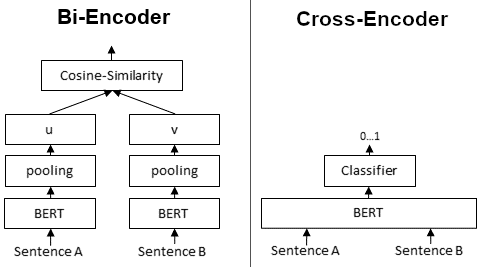

<br>

In [357]:
!pip install sentence_transformers

In [358]:
# Import the CrossEncoder library from sentence_transformers

from sentence_transformers import CrossEncoder, util

In [359]:
# Initialise the cross encoder model

cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

In [360]:
# Test the cross encoder model

scores = cross_encoder.predict([['what tye of insurance this policy provide', 'MEMBER LIFE INSURANCE, MEMBER ACCIDENTAL DEATH AND DISMEMBERMENT INSURANCE, DEPENDENT LIFE INSURANCE'],
                                ['what are premium rate and benefits for each Member insured for Life Insurance?', 'The premium rate(s) for each Member insured for Life Insurance will be: Member Life Insurance $0.210 for each $1,000 of insurance in force. Member Accidental Death and Dismemberment Insurance $0.025 for each $1,000 of Member Life Insurance in force. Dependent Life Insurance  $1.46 for each Member insured for Dependent Life Insurance. If death occurs while Coverage During Disability is in force, The Principal will pay the Member\'s beneficiary the Member Life Insurance benefit amount that would have been paid had the Member remained insured under the Schedule of Insurance in force on the date Total Disability began']])

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [361]:
scores

array([-9.963919,  9.15559 ], dtype=float32)

In [362]:
# Input (query, response) pairs for each of the top 20 responses received from the semantic search to the cross encoder
# Generate the cross_encoder scores for these pairs

cross_inputs = [[query, response] for response in results_df['Documents']]
cross_rerank_scores = cross_encoder.predict(cross_inputs)

In [363]:
cross_inputs

[['Who receives the death benefit in this policy?',
  "M ember's death, the Death Benefits Payable may be withheld until additional information has been received or the trial has been held. If a Member who was insured dies within the 31-day individual purchase period described in PART III, Section F, The Principal will pay his or her beneficiary the individual policy amount, if any, the Member had the right to purchase. No payment will be made before The Principal receives Written proof of the Member's death. Article 3 - Beneficiary A beneficiary should be named at the time a Member applies or enrolls under this Group Policy. A Member may name or later change a named beneficiary by sending a Written request to The Principal. A change will not be effective until recorded by The Principal. Once recorded, the change will apply as of the date the request was Signed. If The Principal properly pays any benefit before a change request is received, that payment may not be contested. Further: a

In [364]:
cross_rerank_scores

array([ 3.1964278,  2.387465 , -2.5450122, -2.610063 , -2.6408122,
       -3.2779603, -2.5027673, -2.7953568, -1.3495269, -5.7853823],
      dtype=float32)

In [365]:
 #Store the rerank_scores in results_df

results_df['Reranked_scores'] = cross_rerank_scores

In [366]:
results_df

,Metadatas,Documents,Distances,IDs,Reranked_scores
0,{'filing_name': 'Principal-Sample-Life-Insuran...,"M ember's death, the Death Benefits Payable ma...",0.263684,46,3.196428
1,"{'Page_No.': 'Page 60', 'filing_name': 'Princi...",I f a Dependent who was insured dies during th...,0.287514,59,2.387465
2,{'filing_name': 'Principal-Sample-Life-Insuran...,c . If a beneficiary dies at the same time or ...,0.312122,47,-2.545012
3,"{'Page_No.': 'Page 54', 'filing_name': 'Princi...","f . claim requirements listed in PART IV, Sect...",0.329244,53,-2.610063
4,{'filing_name': 'Principal-Sample-Life-Insuran...,Section A - Member Life Insurance Schedule of ...,0.349450,7,-2.640812
5,{'filing_name': 'Principal-Sample-Life-Insuran...,(1) only one Accelerated Benefit payment will ...,0.353708,51,-3.277960
6,{'filing_name': 'Principal-Sample-Life-Insuran...,Section C - Dependent Life Insurance Article 1...,0.357332,58,-2.502767
7,"{'Page_No.': 'Page 32', 'filing_name': 'Princi...",(1) marriage or establishment of a Civil Union...,0.358870,31,-2.795357
8,{'filing_name': 'Principal-Sample-Life-Insuran...,PART IV - BENEFITS Section A - Member Life Ins...,0.360286,45,-1.349527
9,"{'Page_No.': 'Page 43', 'filing_name': 'Princi...",Any individual policy issued will then be in f...,0.360855,42,-5.785382


In [367]:
# Return the top 3 results from semantic search
top_3_semantic = results_df.sort_values(by='Distances')
top_3_semantic[:3]

,Metadatas,Documents,Distances,IDs,Reranked_scores
0,{'filing_name': 'Principal-Sample-Life-Insuran...,"M ember's death, the Death Benefits Payable ma...",0.263684,46,3.196428
1,"{'Page_No.': 'Page 60', 'filing_name': 'Princi...",I f a Dependent who was insured dies during th...,0.287514,59,2.387465
2,{'filing_name': 'Principal-Sample-Life-Insuran...,c . If a beneficiary dies at the same time or ...,0.312122,47,-2.545012


In [368]:
# Return the top 3 results after reranking

top_3_rerank = results_df.sort_values(by='Reranked_scores', ascending=False)
top_3_rerank[:3]
top_3_RAG = top_3_rerank[["Documents", "Metadatas"]][:3]

In [369]:
top_3_RAG

,Documents,Metadatas
0,"M ember's death, the Death Benefits Payable ma...",{'filing_name': 'Principal-Sample-Life-Insuran...
1,I f a Dependent who was insured dies during th...,"{'Page_No.': 'Page 60', 'filing_name': 'Princi..."
8,PART IV - BENEFITS Section A - Member Life Ins...,{'filing_name': 'Principal-Sample-Life-Insuran...


## <font color = red>  6. Build the RAG system

In [370]:
retrieved = top_3_RAG[["Documents", "Metadatas"]][:3]

In [371]:
# retrieved = # Just the text from 'Documents' column
retrieved_text = "\n\n".join(top_3_RAG['Documents'].tolist())

In [372]:
retrieved_text

"M ember's death, the Death Benefits Payable may be withheld until additional information has been received or the trial has been held. If a Member who was insured dies within the 31-day individual purchase period described in PART III, Section F, The Principal will pay his or her beneficiary the individual policy amount, if any, the Member had the right to purchase. No payment will be made before The Principal receives Written proof of the Member's death. Article 3 - Beneficiary A beneficiary should be named at the time a Member applies or enrolls under this Group Policy. A Member may name or later change a named beneficiary by sending a Written request to The Principal. A change will not be effective until recorded by The Principal. Once recorded, the change will apply as of the date the request was Signed. If The Principal properly pays any benefit before a change request is received, that payment may not be contested. Further: a. The naming of a new beneficiary in an application fo

In [373]:
messages = [
    {"role":"system", "content":"You are an AI assistant to user."},
    # {"role":"user", "content":f"""what are premium rate and benefits for each Member insured for Life Insurance? You are provided with contents in'{retrieved_text}' """},
    {"role": "user", "content": f"""You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents.
                                                You have a question asked by the user in '{query}' and you have some search results from a corpus of insurance documents in the dataframe '{top_3_RAG}'. These search results are essentially one page of an insurance document that may be relevant to the user query.

                                                The column 'documents' inside this dataframe contains the actual text from the policy document and the column 'metadata' contains the policy name and source page. The text inside the document may also contain tables in the format of a list of lists where each of the nested lists indicates a row.

                                                Use the documents in '{retrieved_text}' to answer the query. Frame an informative answer and also, use the dataframe to return the relevant policy names and page numbers as citations.

                                                Follow the guidelines below when performing the task.
                                                1. Try to provide relevant/accurate numbers if available.
                                                2. You don’t have to necessarily use all the information in the dataframe. Only choose information that is relevant.
                                                3. If the document text has tables with relevant information, please reformat the table and return the final information in a tabular in format.
                                                3. Use the Metadatas columns in the dataframe to retrieve and cite the policy name(s) and page numbers(s) as citation.
                                                4. If you can't provide the complete answer, please also provide any information that will help the user to search specific sections in the relevant cited documents.
                                                5. You are a customer facing assistant, so do not provide any information on internal workings, just answer the query directly.

                                                The generated response should answer the query directly addressing the user and avoiding additional information. If you think that the query is not relevant to the document, reply that the query is irrelevant. Provide the final response as a well-formatted and easily readable text along with the citation. Provide your complete response first with all information, and then provide the citations.
                                                """},
          ]

In [374]:
messages

[{'role': 'system', 'content': 'You are an AI assistant to user.'},
 {'role': 'user',
  'content': "You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents.\n                                                You have a question asked by the user in 'Who receives the death benefit in this policy?' and you have some search results from a corpus of insurance documents in the dataframe '                                           Documents  \\\n0  M ember's death, the Death Benefits Payable ma...   \n1  I f a Dependent who was insured dies during th...   \n8  PART IV - BENEFITS Section A - Member Life Ins...   \n\n                                           Metadatas  \n0  {'filing_name': 'Principal-Sample-Life-Insuran...  \n1  {'Page_No.': 'Page 60', 'filing_name': 'Princi...  \n8  {'filing_name': 'Principal-Sample-Life-Insuran...  '. These search results are essentially one page of an insurance document that may be re

In [375]:
response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages)
response.choices[0].message.content

"Based on the policy document provided, the death benefit in the policy will be paid to the designated beneficiary of the insured member. The beneficiary should be named at the time the member applies or enrolls under the Group Policy. A member may name or later change a named beneficiary by sending a written request to The Principal. The change will not be effective until recorded by The Principal. If the Principal properly pays any benefit before a change request is received, that payment may not be contested.\n\nIf no beneficiary has been designated or if the beneficiary is found guilty of the member's death, the benefit may be paid to a contingent beneficiary or to the executor or administrator of the member's estate.\n\nThe policy document outlines the process and conditions under which the death benefit will be paid, including beneficiary designation, changes, and circumstances that may affect the payment.\n\n**Citations:**\n1. Policy Name: Principal Sample Life Insurance Policy\

## <font color = red> Wrap all at one place

Below solution is not taking inputs from users
- Takes multiple queries at same time
- First try Search in cache, if results for search query found in cache, use it.
- If results are not found, search main collection and store query in cache
- Re-rank and get answer to each query.

In [376]:
def generate_answer(query: str,
                    context_chunks: list[str],
                    model: str = "gpt-3.5-turbo",
                    temperature: float = 0.0,
                    few_shot: list[dict] = None
) -> str:
    # openai.api_key = os.getenv("OPENAI_API_KEY") # API key is already set globally
    client = openai.OpenAI(api_key=os.getenv("OPENAI_API_KEY")) # Use new client
    system_msg = {
        "role": "system",
        "content": (
            "You are an expert assistant for life insurance policies. "
            "Answer using only the provided context."
        )
    }
    user_msg = {
        "role": "user",
        "content": (
            "Context:\n" + "\n---\n".join(context_chunks) +
            f"\n\nQuestion: {query}"
        )
    }
    messages = [system_msg]
    if few_shot:
        messages.extend(few_shot)
    messages.append(user_msg)

    # Use the new chat completions create method
    resp = client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temperature,
        max_tokens=512
    )
    return resp.choices[0].message.content.strip()

In [377]:
def get_rag_results(query, cache_collection, insurancedata_collection, cross_encoder, threshold=0.2, n_results=10):
    """
    Performs the RAG retrieval and re-ranking steps for a given query.

    Args:
        query (str): The user query.
        cache_collection: The ChromaDB collection used for caching.
        insurancedata_collection: The main ChromaDB collection with document embeddings.
        cross_encoder: The cross-encoder model for re-ranking.
        threshold (float, optional): The distance threshold for cache hits. Defaults to 0.2.
        n_results (int, optional): The number of results to retrieve from the main collection. Defaults to 10.

    Returns:
        pandas.DataFrame: A DataFrame containing the re-ranked documents and their metadata.
    """
    ids = []
    documents = []
    distances = []
    metadatas = []
    results_df = pd.DataFrame()

    # Search the Cache collection first
    cache_results = cache_collection.query(
        query_texts=query,
        n_results=1
    )

    # If the distance is greater than the threshold, then return the results from the main collection.
    if not cache_results['distances'][0] or cache_results['distances'][0][0] > threshold:
        # Query the collection against the user query and return the top results
        results = insurancedata_collection.query(
            query_texts=query,
            n_results=n_results,
            include=['metadatas', 'documents', 'distances']
        )

        # Store the query and retrieved results in cache_collection
        Keys = []
        Values = []
        for key, val in results.items():
            if key not in ['embeddings', 'uris', 'data', 'included']:
                if isinstance(val[0], list):
                    for i in range(len(val[0])):
                        Keys.append(f"{key}{i}")
                        Values.append(str(val[0][i]))
                else:
                    Keys.append(f"{key}0")
                    Values.append(str(val[0]))

        # Add to cache, using the query as the ID for simplicity
        if query not in cache_collection.get(ids=[query])['ids']: # Check if query already exists in cache
             cache_collection.add(
                documents=[query],
                ids=[query],
                metadatas=dict(zip(Keys, Values))
            )

        print("Not found in cache. Found in main collection.")

        result_dict = {'Metadatas': results['metadatas'][0], 'Documents': results['documents'][0], 'Distances': results['distances'][0], "IDs": results["ids"][0]}
        results_df = pd.DataFrame.from_dict(result_dict)

    # If the distance is, however, less than the threshold, you can return the results from cache
    elif cache_results['distances'][0][0] <= threshold:
        cache_result_dict = cache_results['metadatas'][0][0]

        # Extract data from the cached metadata
        cached_ids = [v for k, v in cache_result_dict.items() if 'ids' in k]
        cached_documents = [v for k, v in cache_result_dict.items() if 'documents' in k]
        cached_distances = [float(v) for k, v in cache_result_dict.items() if 'distances' in k]
        cached_metadatas = [eval(v) for k, v in cache_result_dict.items() if 'metadatas' in k] # Use eval to convert string back to dict

        print("Found in cache!")

        # Create a DataFrame from cached data
        results_df = pd.DataFrame({
          'IDs': cached_ids,
          'Documents': cached_documents,
          'Distances': cached_distances,
          'Metadatas': cached_metadatas
        })


    # Re-rank the results
    if not results_df.empty:
        cross_inputs = [[query, response] for response in results_df['Documents']]
        results_df['Reranked_scores'] = cross_encoder.predict(cross_inputs)
        # Sort by re-ranked scores in descending order
        results_df = results_df.sort_values(by='Reranked_scores', ascending=False).reset_index(drop=True)

    return results_df

In [378]:
# Assuming you have a list of queries
queries = [
    "What are the policy exclusions?",
    "Explain the grace period rules.",
    "How do I file a death claim?"
]

# Assuming you have initialized your ChromaDB collections (insurancedata_collection, cache_collection)
# and your cross_encoder model

for query in queries:
    print(f"\n--- Processing Query: {query} ---")

    # Get RAG results (retrieval and re-ranking)
    rag_results_df = get_rag_results(query, cache_collection, insurancedata_collection, cross_encoder)

    # Extract the top documents for generation
    top_documents = rag_results_df['Documents'].tolist()[:3] # Take the top 3 re-ranked documents

    # Generate the final answer using the retrieved documents as context
    final_answer = generate_answer(query, top_documents)

    print("\n--- Generated Answer ---")
    print(final_answer)
    print("-" * 30)


--- Processing Query: What are the policy exclusions? ---
Found in cache!


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



--- Generated Answer ---
The policy exclusions include that the term Physician does not include the Member, an employee of the Member, a business or professional partner or associate of the Member, any person who has a financial affiliation or business interest with the Member, anyone related to the Member by blood or marriage, or anyone living in the Member's household.
------------------------------

--- Processing Query: Explain the grace period rules. ---
Found in cache!


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



--- Generated Answer ---
The grace period allows for a 31-day period following a premium due date for payment to be made. The Group Policy will remain in force until the end of the grace period, unless terminated by notice. The Policyholder is responsible for payment during the grace period.
------------------------------

--- Processing Query: How do I file a death claim? ---
Found in cache!


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



--- Generated Answer ---
To file a death claim, a written notice must be sent to The Principal within 20 days after the date of the loss. The Principal will provide appropriate claim forms for filing proof of loss upon receiving the notice. Written proof of loss, including the date, nature, and extent of the loss, must be sent to The Principal within 90 days after the date of the loss. The Principal may request additional information to substantiate the loss. If a Member who was insured dies within the 31-day individual purchase period, the beneficiary will receive the individual policy amount after providing written proof of the Member's death.
------------------------------


## Query by user console

In [379]:
user_query = input("Please enter your insurance policy question: ")

print(f"\n--- Processing Query: {user_query} ---")

# Get RAG results (retrieval and re-ranking)
rag_results_df = get_rag_results(user_query, cache_collection, insurancedata_collection, cross_encoder)

# Extract the top documents for generation
top_documents = rag_results_df['Documents'].tolist()[:3] # Take the top 3 re-ranked documents

# Generate the final answer using the retrieved documents as context
final_answer = generate_answer(user_query, top_documents)

print("\n--- Generated Answer ---")
print(final_answer)
print("-" * 30)

Please enter your insurance policy question: Are there any conditions for the payout of the death benefit?

--- Processing Query: Are there any conditions for the payout of the death benefit? ---
Not found in cache. Found in main collection.


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



--- Generated Answer ---
Yes, there are conditions for the payout of the death benefit. The death benefit will be paid only after The Principal receives Written proof of the Member's death. Additionally, there are specific provisions regarding beneficiaries, including the naming or changing of beneficiaries, the order of precedence for payment if no beneficiary survives the Member, and the disqualification of beneficiaries under certain circumstances.
------------------------------
